In [36]:
# Import necessary packages

import pyupbit

import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt

In [17]:
tickers = pyupbit.get_tickers(fiat='KRW')

# Weekly Bitcoin OHLCV
bitcoin = pyupbit.get_ohlcv(tickers[0], count=600, interval='week', period=1)

In [18]:
bitcoin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4978000.0,4175000.0,4962000.0,374.805189,1.677939e+09
2017-10-02 09:00:00,4962000.0,5263000.0,4811000.0,5217000.0,231.455318,1.163689e+09
2017-10-09 09:00:00,5222000.0,6950000.0,5188000.0,6381000.0,82.704757,4.960136e+08
2017-10-16 09:00:00,6403000.0,7253000.0,5876000.0,7039000.0,106.952135,6.822296e+08
2017-10-23 09:00:00,7017000.0,7100000.0,6212000.0,6961000.0,2141.265727,1.436444e+10
...,...,...,...,...,...,...
2024-01-29 09:00:00,57855000.0,59863000.0,57561000.0,58811000.0,18360.955218,1.081423e+12
2024-02-05 09:00:00,58814000.0,65500000.0,58311000.0,65230000.0,28545.037161,1.772010e+12
2024-02-12 09:00:00,65231000.0,72500000.0,64887000.0,71964000.0,44590.991559,3.099675e+12
2024-02-19 09:00:00,71968000.0,73100000.0,70542000.0,71256000.0,23116.327711,1.657007e+12


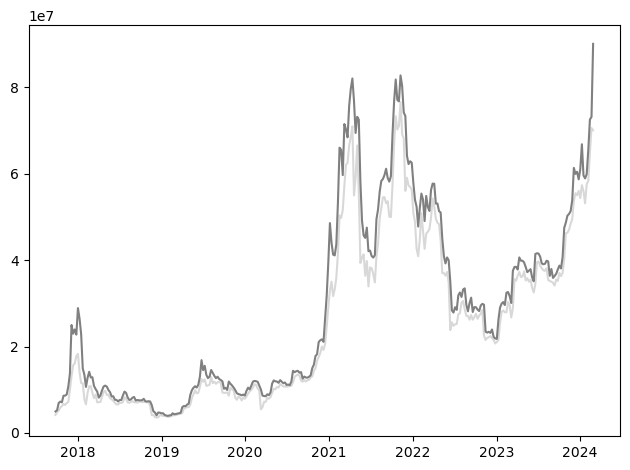

In [21]:
# Visualize the Bitcoin price (BTC-KRW)

fig, ax = plt.subplots()

#ax.plot(bitcoin.close, color='navy', label='Close')
ax.plot(bitcoin.high, color='gray', label='High')
ax.plot(bitcoin.low, color='gray', label='Low', alpha=.3)

fig.tight_layout()

In [34]:
close = bitcoin.close

ma_density = pd.DataFrame()
n = 50

for i in range(len(close)-n+1):
    ma = close[i:n+i].reset_index(drop=True)
    ma_density = pd.concat([ma_density, ma.rename(i)], axis=1)

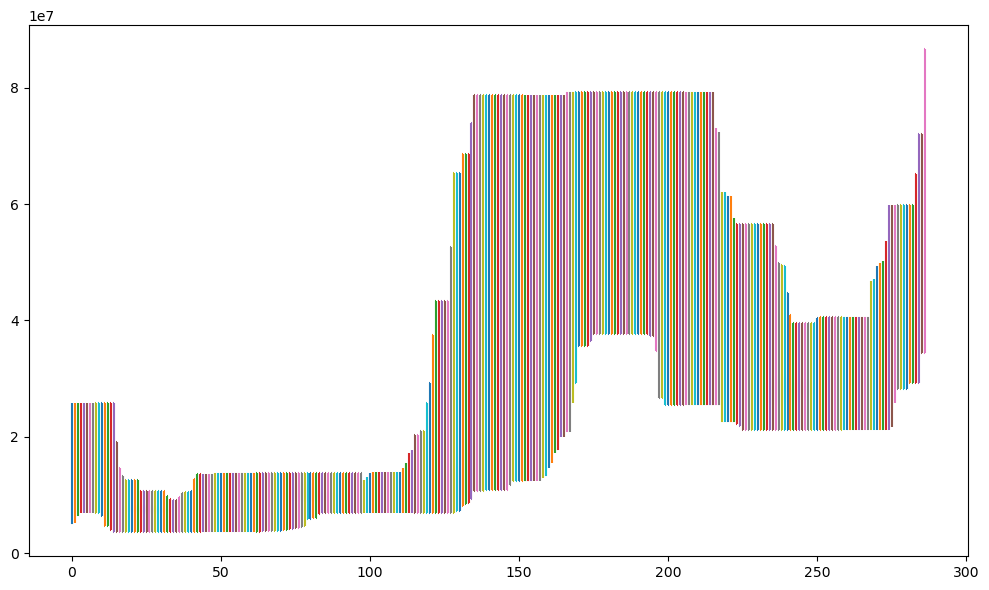

In [83]:
data = ma_density.iloc[:, :]

fig, ax = plt.subplots(figsize=(10, 6))

for col in data.columns:
    dt = data.iloc[:, col]
    #ax.scatter(x=np.array([col] * len(dt)), y=dt, color='gray', alpha=0.4)
    ax.violinplot(dt, positions=[col], widths=0.45, bw_method="silverman", showmeans=True, showmedians=False, showextrema=True)

#ax.set_ylim([0, 30000000])
fig.tight_layout()

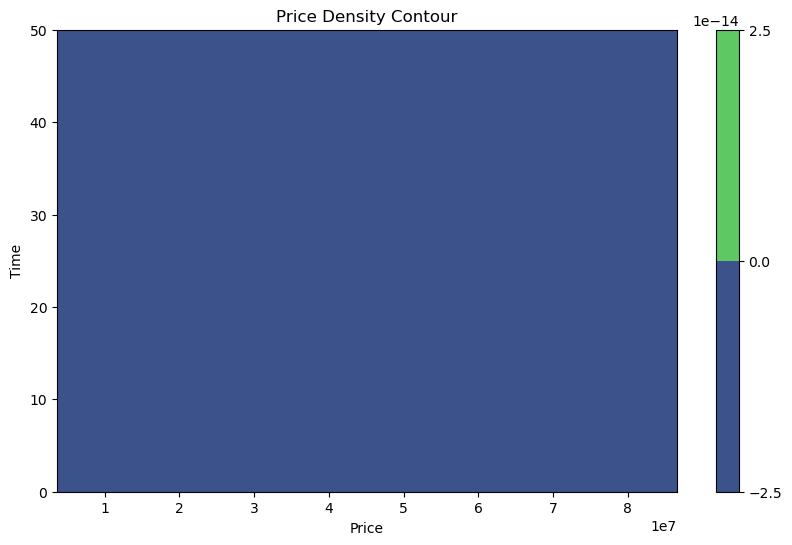

In [37]:
# 예시 데이터 생성
data = ma_density.copy()

# KDE 모델 생성 및 피팅
kde_models = {}
for column in data.columns:
    kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
    kde.fit(data[column].values[:, np.newaxis])
    kde_models[column] = kde

# 적절한 범위의 가격 데이터에 대한 빈도 계산
x = np.linspace(data.min().min(), data.max().max(), 1000)
y = np.linspace(0, len(data), 1000)

X, Y = np.meshgrid(x, y)
values = np.zeros_like(X)
for i, column in enumerate(data.columns):
    values += np.exp(kde_models[column].score_samples(X[:, i][:, np.newaxis]))

# Contour plot 그리기
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, values, cmap='viridis')  # cmap은 적절하게 선택
fig.colorbar(contour, ax=ax)
ax.set_xlabel('Price')
ax.set_ylabel('Time')
ax.set_title('Price Density Contour')
plt.show()

## **Biais, Disière, Bouvard, Casamatta, Menkveld (2023)**

In [49]:
def calculate_frequency(realized_data, num_bins=10):
    # 데이터의 최솟값과 최댓값을 구합니다.
    min_value = realized_data.min()
    max_value = realized_data.max()

    # 구간(bin)을 생성합니다.
    bins = np.linspace(min_value, max_value, num_bins + 1)

    # 각 데이터 포인트를 해당하는 구간에 할당합니다.
    binned_data = np.digitize(realized_data, bins)

    # 각 구간에 속하는 데이터의 빈도를 계산합니다.
    frequency = np.histogram(binned_data, bins=np.arange(1, len(bins) + 1))[0]

    # 결과를 DataFrame으로 반환합니다.
    frequency_df = pd.DataFrame({'Bin': np.arange(1, len(bins)), 'Frequency': frequency})
    frequency_df.set_index('Bin', inplace=True)

    return frequency_df

# 예시 데이터 생성
realized_data = pd.Series(np.random.randn(100))

# 적절한 bin을 생성하여 빈도를 계산합니다.
frequency_df = calculate_frequency(realized_data, num_bins=10)

print(frequency_df)

     Frequency
Bin           
1            3
2           10
3            7
4           10
5           19
6           14
7           18
8           10
9            6
10           3
